In [1]:
import tensorflow as tf
import os,shutil
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Dropout,Flatten, Dense 
np.set_printoptions(threshold=np.inf)
from tensorflow.keras import Model

In [2]:
original_dataset_dir='D:/机器学习+毕设+java资料/吴恩达/cat vs dog/dc/train'
base_dir='D:/机器学习+毕设+java资料/吴恩达/cat vs dog/dc/find_cats_and_dogs'
train_dir=os.path.join(base_dir,'train')

validation_dir=os.path.join(base_dir,'validaiton')

test_dir=os.path.join(base_dir,'test')

train_cats_dir = os.path.join(train_dir, 'cats')

train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')

validation_dogs_dir = os.path.join(validation_dir, 'dogs')

test_cats_dir = os.path.join(test_dir, 'cats')

test_dogs_dir = os.path.join(test_dir, 'dogs')

In [3]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 6000
total training dog images: 6000
total validation cat images: 2000
total validation dog images: 2000
total test cat images: 2000
total test dog images: 2000


In [4]:
from keras.preprocessing.image import ImageDataGenerator
# 训练数据的增强
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# 不能增强验证数据
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,  # 目标目录
    target_size=(150,150),  # 大小调整
    batch_size=16,
    class_mode="binary"
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    batch_size=16,
    class_mode="binary"
)


Found 12000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


In [5]:
#数据增强处理
datagen = ImageDataGenerator(
    rotation_range=40,  # 0-180的角度值
    width_shift_range=0.2,  # 水平和垂直方向的范围；相对于总宽度或者高度的比例
    height_shift_range=0.2,
    shear_range=0.2,  # 随机错切变换的角度
    zoom_range=0.2,  # 图像随机缩放的角度
    horizontal_flip=True,  # 随机将一半图像进行水平翻转
    fill_mode="nearest"  # 用于填充新创建像素的方法
)

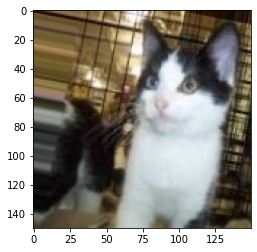

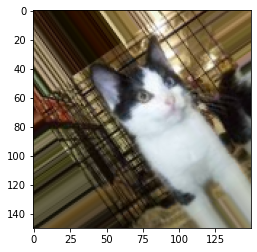

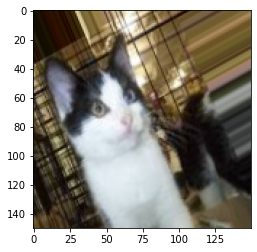

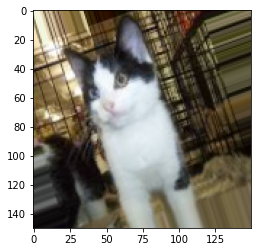

In [6]:
#数据增强
from keras.preprocessing import image

fnames = [os.path.join(train_cats_dir,fname) for fname in os.listdir(train_cats_dir)]
img_path = fnames[3]
# 读取图片并调整大小
img = image.load_img(img_path, target_size=(150,150))  
# 转成数组
x = image.img_to_array(img)

# shape转成(1,150,150,3)
x = x.reshape((1,) + x.shape)

i = 0
for batch in datagen.flow(x, batch_size=1):  # 生成随机变换后的图像批量
    plt.figure()   
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break  # 循环是无限，需要在某个时刻终止
        
plt.show()

In [7]:
class ResnetBlock(Model):
    def __init__(self,filters,strides=1,residual_path=False):
        super(ResnetBlock,self).__init__()
        self.filters=filters
        self.strides=strides
        self.residual_path=residual_path
        self.c1=Conv2D(filters,(3,3),strides=strides,padding='same',use_bias=False)
        self.b1=BatchNormalization()
        self.a1=Activation('relu')
        self.c2=Conv2D(filters,(3,3),strides=1,padding='same',use_bias=False)
        self.b2=BatchNormalization()
        # residual_path为True时，对输入进行下采样，即用1x1的卷积核做卷积操作，保证x能和F(x)维度相同，顺利相加
        if residual_path:
            self.down_c1=Conv2D(filters,(1,1),strides=strides,padding='same',use_bias=False)
            self.down_b1=BatchNormalization()
        self.a2=Activation('relu')
    def call(self,inputs):
        residual=inputs # residual等于输入值本身，即residual=x
        x=self.c1(inputs)
        x=self.b1(x)
        x=self.a1(x)
        x=self.c2(x)
        y=self.b2(x)
        if self.residual_path:
            residual=self.down_c1(inputs)
            residual=self.down_b1(residual)
        out=self.a2(y+residual)
        return out
          

In [8]:
class ResNet(Model):
    def __init__(self,block_list,initial_filters=64): # block_list表示每个block有几个卷积层
        super(ResNet,self).__init__()
        self.num_blocks=len(block_list)#有多少个残差block
        self.block_list=block_list
        self.out_filters=initial_filters
        self.c1=Conv2D(self.out_filters,(3,3),strides=1,padding='same')
        self.b1=BatchNormalization()
        self.a1=Activation('relu')
        self.blocks=tf.keras.models.Sequential()
        for block_id in range(len(block_list)):# 第几个resnet block
            for layer_id in range(block_list[block_id]):# 第几个卷积层,每个block有两卷积
                if block_id!=0 and layer_id ==0:
                    # 对除第一个block以外的每个block的输入进行下采样
                    #每个block两层，第一个block不需要下采样，而其他的，第一层都要下采样
                    block=ResnetBlock(self.out_filters,strides=2,residual_path=True)
                else:
                    block=ResnetBlock(self.out_filters,residual_path=False)
                self.blocks.add(block)
            self.out_filters*=2
        self.p1 = tf.keras.layers.GlobalAveragePooling2D()
        self.f1 = tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2()) 
    def call(self, inputs):
        x = self.c1(inputs)
        x = self.b1(x)
        x = self.a1(x)
        x = self.blocks(x)
        x = self.p1(x)
        y = self.f1(x)
        return y   

In [10]:
model = ResNet([2, 2, 2, 2])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
             metrics=['accuracy'])
checkpoint_save_path="./checkpoint/ResNet18.ckpt"
if os.path.exists(checkpoint_save_path+'.index'):
    print('--------加载模型-------')
    model.load_weights(checkpoint_save_path)
cp_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                              save_weights_only=True,
                                              save_best_only=True)

In [12]:
model.build(input_shape=(None, 150,150,3))
model.summary()

Model: "res_net_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           multiple                  1792      
_________________________________________________________________
batch_normalization_20 (Batc multiple                  256       
_________________________________________________________________
activation_17 (Activation)   multiple                  0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 19, 19, 512)       11176448  
_________________________________________________________________
global_average_pooling2d_1 ( multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  513       
Total params: 11,179,009
Trainable params: 11,169,409
Non-trainable params: 9,600
_________________________________________

In [13]:
history=model.fit(
      train_generator,
      steps_per_epoch=750,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=250,
    callbacks=[cp_callback])

Epoch 1/50
750/750 [==============================] - 158s 202ms/step - loss: 0.6871 - accuracy: 0.6143 - val_loss: 0.6755 - val_accuracy: 0.6130
Epoch 2/50
750/750 [==============================] - 150s 200ms/step - loss: 0.6363 - accuracy: 0.6547 - val_loss: 0.6006 - val_accuracy: 0.6935
Epoch 3/50
750/750 [==============================] - 148s 198ms/step - loss: 0.6119 - accuracy: 0.6847 - val_loss: 0.6766 - val_accuracy: 0.6525
Epoch 4/50
750/750 [==============================] - 148s 198ms/step - loss: 0.5733 - accuracy: 0.7179 - val_loss: 0.5628 - val_accuracy: 0.7337
Epoch 5/50
750/750 [==============================] - 148s 198ms/step - loss: 0.5485 - accuracy: 0.7334 - val_loss: 0.6201 - val_accuracy: 0.7293
Epoch 6/50
750/750 [==============================] - 149s 199ms/step - loss: 0.5305 - accuracy: 0.7463 - val_loss: 0.5531 - val_accuracy: 0.7552
Epoch 7/50
750/750 [==============================] - 149s 199ms/step - loss: 0.4872 - accuracy: 0.7772 - val_loss: 0.5156 -

In [ ]:
history=model.fit(
      train_generator,
      steps_per_epoch=750,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=250,
    callbacks=[cp_callback])

Text(0.5, 1.0, 'Training and validation loss')

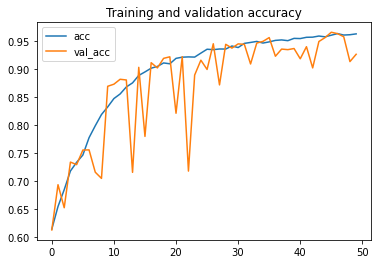

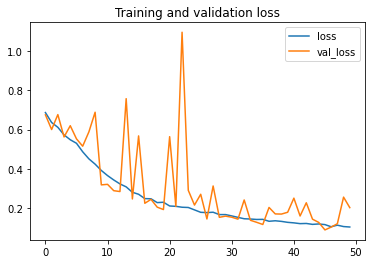

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs   = range(len(acc))
plt.plot  ( epochs,     acc ,label='acc')
plt.plot  ( epochs, val_acc ,label='val_acc')
plt.legend(loc='best')
plt.title ('Training and validation accuracy')
plt.figure()
plt.plot  ( epochs,     loss ,label='loss')
plt.plot  ( epochs, val_loss ,label='val_loss')
plt.legend(loc='best')
plt.title ('Training and validation loss')

In [21]:
model.save_weights("resnet_weight.h5")

In [22]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=16,
    class_mode='binary')

Found 4000 images belonging to 2 classes.


In [23]:
test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('test acc:', test_acc)

50/50 [==============================] - 3s 50ms/step - loss: 0.2790 - accuracy: 0.9087
test acc: 0.9087499976158142
